#### Details
- Analyze the data leading up to the Volkswagen buyout of Porsche
- Compare what models describe the stock best (before and after buyout anouncement)
- Comment on the results
- Analyze how dieselgate scandal of September 2015 affected the buyout

## Import the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Import the data

In [2]:
raw_data = yfinance.download(tickers = 'VOW3.DE, PAH3.DE, BMW.DE', interval = '1d', group_by = 'ticker',
                             auto_adjust = True, threads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
df = raw_data.copy() # Create checkpoint
df.head()

Ticker                    PAH3.DE                          BMW.DE            \
Price                        Open High Low Close Volume      Open      High   
Date                                                                          
1996-11-08 00:00:00+00:00     NaN  NaN NaN   NaN    NaN  8.117676  8.117676   
1996-11-11 00:00:00+00:00     NaN  NaN NaN   NaN    NaN  8.108760  8.113218   
1996-11-12 00:00:00+00:00     NaN  NaN NaN   NaN    NaN  8.095832  8.170278   
1996-11-13 00:00:00+00:00     NaN  NaN NaN   NaN    NaN  8.177413  8.177413   
1996-11-14 00:00:00+00:00     NaN  NaN NaN   NaN    NaN  8.115446  8.152891   

Ticker                                                 VOW3.DE                 \
Price                           Low     Close   Volume    Open High Low Close   
Date                                                                            
1996-11-08 00:00:00+00:00  8.100290  8.100290   767000     NaN  NaN NaN   NaN   
1996-11-11 00:00:00+00:00  8.060616  8.078446   260000     NaN  NaN NaN   NaN   
1996-11-12 00:00:00+00:00  8.065073  8.139520  1066000     NaN  NaN NaN   NaN   
1996-11-13 00:00:00+00:00  8.108763  8.126594   793000     NaN  NaN NaN   NaN   
1996-11-14 00:00:00+00:00  8.082904  8.152891   351000     NaN  NaN NaN   NaN   

Ticker                            
Price                     Volume  
Date                              
1996-11-08 00:00:00+00:00    NaN  
1996-11-11 00:00:00+00:00    NaN  
1996-11-12 00:00:00+00:00    NaN  
1996-11-13 00:00:00+00:00    NaN  
1996-11-14 00:00:00+00:00    NaN

## Define Key Dates

In [4]:
start_date = '2009-04-05' # Starting date
ann_1 = '2009-12-09' # First official buyout announcement - 49.9%
ann_2 = '2012-07-05' # Second official buyout announcement -50.1%
end_date = '2014-01-01' # Ending date
d_gate = '2015-09-20' # Dieselgate scandal

## Preprocessing

In [5]:
# Extract closing prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

#Creating returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating squared returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por) 
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extract volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [6]:
# Set the frequency and fill the Nan values
df = df.asfreq('b')
df = df.fillna(method='bfill')
df.head()

Ticker                       PAH3.DE                                   \
Price                           Open       High        Low      Close   
Date                                                                    
1996-11-08 00:00:00+00:00  23.808226  25.131495  23.515937  24.828577   
1996-11-11 00:00:00+00:00  23.808226  25.131495  23.515937  24.828577   
1996-11-12 00:00:00+00:00  23.808226  25.131495  23.515937  24.828577   
1996-11-13 00:00:00+00:00  23.808226  25.131495  23.515937  24.828577   
1996-11-14 00:00:00+00:00  23.808226  25.131495  23.515937  24.828577   

Ticker                                 BMW.DE                                \
Price                        Volume      Open      High       Low     Close   
Date                                                                          
1996-11-08 00:00:00+00:00  901566.0  8.117676  8.117676  8.100290  8.100290   
1996-11-11 00:00:00+00:00  901566.0  8.108760  8.113218  8.060616  8.078446   
1996-11-12 00:00:00+00:00  901566.0  8.095832  8.170278  8.065073  8.139520   
1996-11-13 00:00:00+00:00  901566.0  8.177413  8.177413  8.108763  8.126594   
1996-11-14 00:00:00+00:00  901566.0  8.115446  8.152891  8.082904  8.152891   

Ticker                                ...       bmw   ret_vol   ret_por  \
Price                         Volume  ...                                 
Date                                  ...                                 
1996-11-08 00:00:00+00:00   767000.0  ...  8.100290 -4.405639 -3.831325   
1996-11-11 00:00:00+00:00   260000.0  ...  8.078446 -4.405639 -3.831325   
1996-11-12 00:00:00+00:00  1066000.0  ...  8.139520 -4.405639 -3.831325   
1996-11-13 00:00:00+00:00   793000.0  ...  8.126594 -4.405639 -3.831325   
1996-11-14 00:00:00+00:00   351000.0  ...  8.152891 -4.405639 -3.831325   

Ticker                      ret_bmw     sq_vol    sq_por    sq_bmw    q_vol  \
Price                                                                         
Date                                                                          
1996-11-08 00:00:00+00:00 -0.269668  19.409654  14.67905  0.072721  56336.0   
1996-11-11 00:00:00+00:00 -0.269668  19.409654  14.67905  0.072721  56336.0   
1996-11-12 00:00:00+00:00  0.756003  19.409654  14.67905  0.571541  56336.0   
1996-11-13 00:00:00+00:00 -0.158807  19.409654  14.67905  0.025220  56336.0   
1996-11-14 00:00:00+00:00  0.323599  19.409654  14.67905  0.104716  56336.0   

Ticker                        q_por      q_bmw  
Price                                           
Date                                            
1996-11-08 00:00:00+00:00  901566.0   767000.0  
1996-11-11 00:00:00+00:00  901566.0   260000.0  
1996-11-12 00:00:00+00:00  901566.0  1066000.0  
1996-11-13 00:00:00+00:00  901566.0   793000.0  
1996-11-14 00:00:00+00:00  901566.0   351000.0  

[5 rows x 27 columns]

In [7]:
# Remove surplus data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']
df.head()

Ticker,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
1996-11-08 00:00:00+00:00,21.980986,24.828577,8.100290,-4.405639,-3.831325,-0.269668,19.409654,14.67905,0.072721,56336.0,901566.0,767000.0
1996-11-11 00:00:00+00:00,21.980986,24.828577,8.078446,-4.405639,-3.831325,-0.269668,19.409654,14.67905,0.072721,56336.0,901566.0,260000.0
1996-11-12 00:00:00+00:00,21.980986,24.828577,8.139520,-4.405639,-3.831325,0.756003,19.409654,14.67905,0.571541,56336.0,901566.0,1066000.0
1996-11-13 00:00:00+00:00,21.980986,24.828577,8.126594,-4.405639,-3.831325,-0.158807,19.409654,14.67905,0.025220,56336.0,901566.0,793000.0
1996-11-14 00:00:00+00:00,21.980986,24.828577,8.152891,-4.405639,-3.831325,0.323599,19.409654,14.67905,0.104716,56336.0,901566.0,351000.0


## Plot the prices

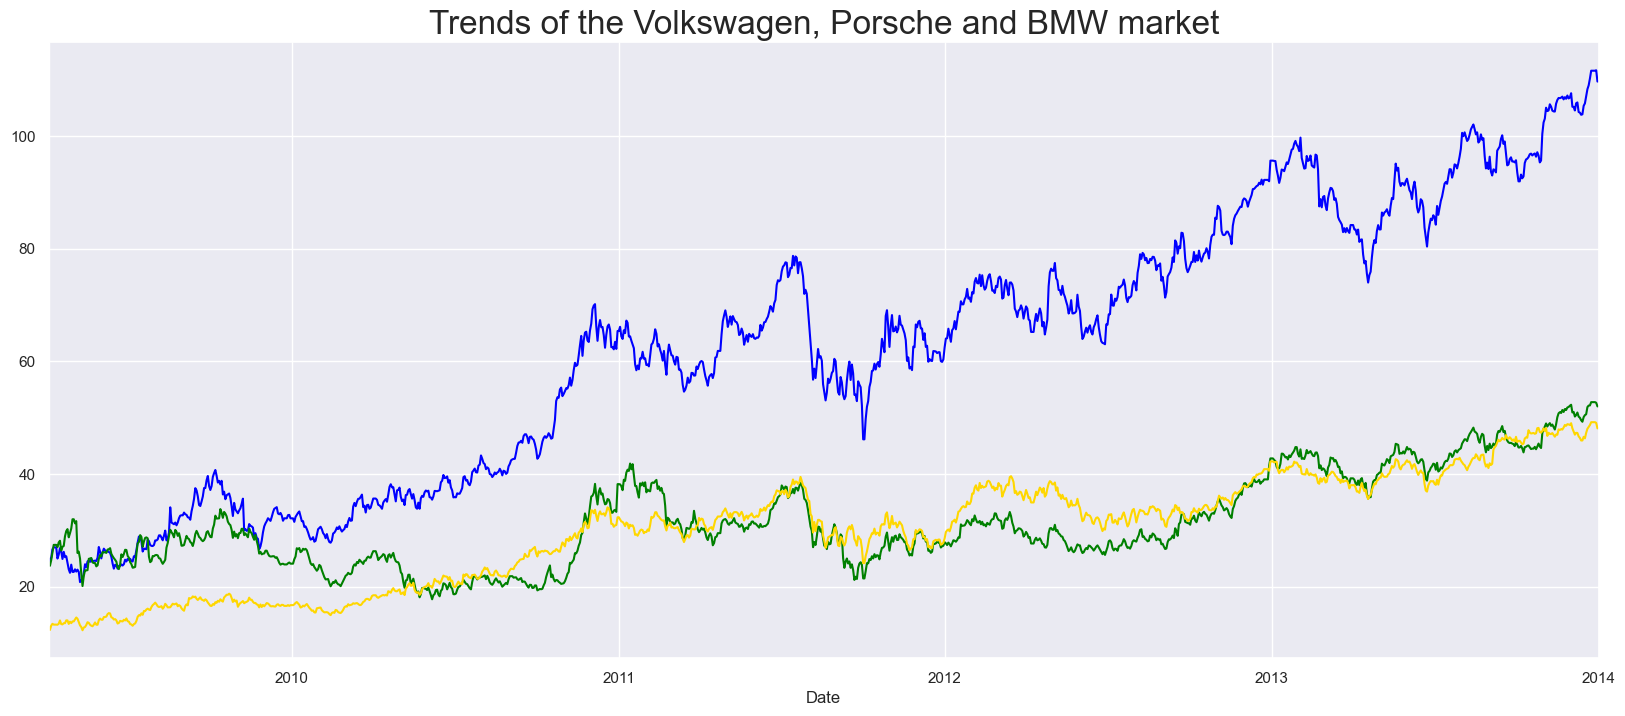

In [8]:
# Plotting the trends from the starting to the end date
df['vol'][start_date:end_date].plot(figsize=(20, 8), color='blue')
df['por'][start_date:end_date].plot(color='green')
df['bmw'][start_date:end_date].plot(color='gold')
plt.title('Trends of the Volkswagen, Porsche and BMW market', size=24)
plt.show()

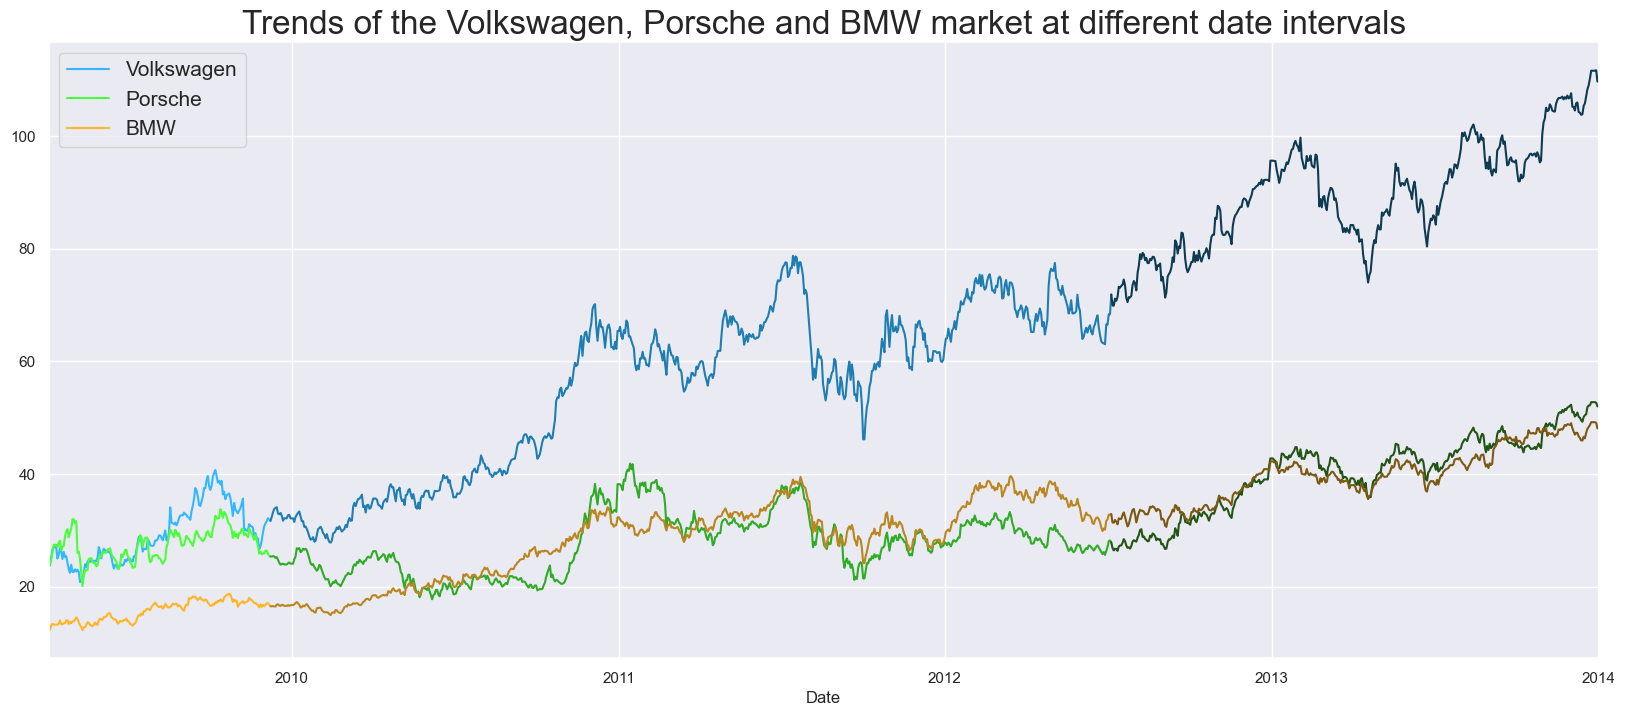

In [9]:
# Plot the trend intervals of each recorded dates
df['vol'][start_date:ann_1].plot(figsize=(20, 8), color='#33B8FF')
df['por'][start_date:ann_1].plot(color='#49FF3A')
df['bmw'][start_date:ann_1].plot(color='#FEB628')

df['vol'][ann_1:ann_2].plot(color='#1E7EB2')
df['por'][ann_1:ann_2].plot(color='#2FAB25')
df['bmw'][ann_1:ann_2].plot(color='#BA861F')

df['vol'][ann_2:end_date].plot(color='#0E3A52')
df['por'][ann_2:end_date].plot(color='#225414')
df['bmw'][ann_2:end_date].plot(color='#7C5913')

plt.legend(['Volkswagen', 'Porsche', 'BMW'], fontsize=15)
plt.title('Trends of the Volkswagen, Porsche and BMW market at different date intervals', size=24)
plt.show()

## Correlation

In [10]:
# Correlation from starting date to the end date
print(f"Correlation among manufacturers from {start_date} to {end_date}" + '\n')
print(f"Volkswagen and Porsche correlation: \t {df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])}")
print(f"Volkswagen and BMW correlation: \t {df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])}")
print(f"Porsche and BMW correlation: \t\t {df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])}")

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	 0.8359546997042031
Volkswagen and BMW correlation: 	 0.979937826781634
Porsche and BMW correlation: 		 0.8052157723354006


In [11]:
# Correlation from starting date to first announcement date
print(f"Correlation among manufacturers from {start_date} to {ann_1}" + '\n')
print(f"Volkswagen and Porsche correlation: \t {df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])}")
print(f"Volkswagen and BMW correlation: \t {df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])}")
print(f"Porsche and BMW correlation: \t\t {df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])}")

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	 0.6633584549695088
Volkswagen and BMW correlation: 	 0.8427607942064562
Porsche and BMW correlation: 		 0.6095040220356073


In [12]:
# Correlation from the first announcement to second announcement date
print(f"Correlation among manufacturers from {ann_1} to {ann_2}" + '\n')
print(f"Volkswagen and Porsche correlation: \t {df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])}")
print(f"Volkswagen and BMW correlation: \t {df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])}")
print(f"Porsche and BMW correlation: \t\t {df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])}")

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	 0.7428267803452699
Volkswagen and BMW correlation: 	 0.979594302002377
Porsche and BMW correlation: 		 0.7042723188593131


In [13]:
# Correlation from second announcement to the end date
print(f"Correlation among manufacturers from {ann_2} to {end_date}" + '\n')
print(f"Volkswagen and Porsche correlation: \t {df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])}")
print(f"Volkswagen and BMW correlation: \t {df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])}")
print(f"Porsche and BMW correlation: \t\t {df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])}")

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	 0.9405237265622632
Volkswagen and BMW correlation: 	 0.9284447755977857
Porsche and BMW correlation: 		 0.9494111733340622


In [14]:
# Correlation of the end date
print(f"Correlation among manufacturers from {end_date} to {df.index[-1]}" + '\n')
print(f"Volkswagen and Porsche correlation: \t {df['vol'][end_date:].corr(df['por'][end_date:])}")
print(f"Volkswagen and BMW correlation: \t {df['vol'][end_date:].corr(df['bmw'][end_date:])}")
print(f"Porsche and BMW correlation: \t\t {df['por'][end_date:].corr(df['bmw'][end_date:])}")

Correlation among manufacturers from 2014-01-01 to 2024-10-04 00:00:00+00:00

Volkswagen and Porsche correlation: 	 0.85501158809649
Volkswagen and BMW correlation: 	 0.502162354270477
Porsche and BMW correlation: 		 0.2746896149056295


## Best fitting models for Prices

### For Volkswagen

In [15]:
# Best model before announcement
model_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous=df[['por', 'bmw']][start_date:ann_1], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the first announcement
model_btw_vol = auto_arima(df.vol[ann_1:ann_2], exogenous=df[['por', 'bmw']][ann_1:ann_2], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the second announcement
model_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous=df[['por', 'bmw']][ann_2:end_date], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

In [16]:
model_pre_vol.summary() # Summary of first model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -258.661
Date:                Sun, 06 Oct 2024   AIC                            519.322
Time:                        06:46:15   BIC                            522.498
Sample:                    04-06-2009   HQIC                           520.610
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0885      0.061     17.983      0.000       0.970       1.207
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
model_btw_vol.summary() # Summary of second model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1165.688
Date:                Sun, 06 Oct 2024   AIC                           2335.377
Time:                        06:46:15   BIC                           2344.394
Sample:                    12-09-2009   HQIC                          2338.869
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0899      0.034      2.645      0.008       0.023       0.156
sigma2         1.8900      0.076     24.998      0.000       1.742       2.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                85.28
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.54   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
model_post_vol.summary() # Summary of third model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -660.173
Date:                Sun, 06 Oct 2024   AIC                           1324.345
Time:                        06:46:15   BIC                           1332.273
Sample:                    07-05-2012   HQIC                          1327.488
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0879      0.047      1.861      0.063      -0.005       0.180
sigma2         1.7442      0.091     19.175      0.000       1.566       1.922
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                61.79
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.15
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## For Porsche

In [19]:
# Best model before announcement
model_pre_por = auto_arima(df.por[start_date:ann_1], exogenous=df[['vol', 'bmw']][start_date:ann_1], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the first announcement
model_btw_por = auto_arima(df.por[ann_1:ann_2], exogenous=df[['vol', 'bmw']][ann_1:ann_2], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the second announcement
model_post_por = auto_arima(df.por[ann_2:end_date], exogenous=df[['vol', 'bmw']][ann_2:end_date], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

In [20]:
model_pre_por.summary() # Summary of first model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -245.755
Date:                Sun, 06 Oct 2024   AIC                            493.510
Time:                        06:46:40   BIC                            496.686
Sample:                    04-06-2009   HQIC                           494.798
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9408      0.050     19.004      0.000       0.844       1.038
===================================================================================
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model_btw_por.summary() # Summary of second model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -786.229
Date:                Sun, 06 Oct 2024   AIC                           1576.457
Time:                        06:46:40   BIC                           1585.475
Sample:                    12-09-2009   HQIC                          1579.950
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1096      0.032      3.457      0.001       0.047       0.172
sigma2         0.6099      0.019     32.054      0.000       0.573       0.647
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               483.16
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
model_post_por.summary() # Summary of second model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -395.621
Date:                Sun, 06 Oct 2024   AIC                            795.242
Time:                        06:46:40   BIC                            803.169
Sample:                    07-05-2012   HQIC                           798.384
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0620      0.034      1.824      0.068      -0.005       0.129
sigma2         0.4476      0.025     17.659      0.000       0.398       0.497
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                25.52
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.14
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best fitting model for Returns

### For Volkswagen

In [23]:
# Best model before announcement
model_pre_ret_vol = auto_arima(df.ret_vol[1:][start_date:ann_1], exogenous=df[['ret_por', 'ret_bmw']][1:][start_date:ann_1], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the first announcement
model_btw_ret_vol = auto_arima(df.ret_vol[1:][ann_1:ann_2], exogenous=df[['ret_por', 'ret_bmw']][1:][ann_1:ann_2], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the second announcement
model_post_ret_vol = auto_arima(df.ret_vol[1:][ann_2:end_date], exogenous=df[['ret_por', 'ret_bmw']][1:][ann_2:end_date], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

In [24]:
model_pre_ret_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:                        SARIMAX   Log Likelihood                -476.453
Date:                Sun, 06 Oct 2024   AIC                            954.907
Time:                        06:46:55   BIC                            958.088
Sample:                    04-06-2009   HQIC                           956.197
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        12.3732      0.835     14.826      0.000      10.737      14.009
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                70.40
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.26
Prob(H) (two-sided):                  0.93   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
model_btw_ret_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1558.900
Date:                Sun, 06 Oct 2024   AIC                           3121.799
Time:                        06:46:56   BIC                           3130.820
Sample:                    12-09-2009   HQIC                          3125.293
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1303      0.029      4.473      0.000       0.073       0.187
sigma2         6.0598      0.249     24.295      0.000       5.571       6.549
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                67.50
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
model_post_ret_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -729.133
Date:                Sun, 06 Oct 2024   AIC                           1464.266
Time:                        06:46:56   BIC                           1476.165
Sample:                    07-05-2012   HQIC                          1468.983
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1533      0.079      1.932      0.053      -0.002       0.309
ar.L1          0.1030      0.045      2.300      0.021       0.015       0.191
sigma2         2.4626      0.136     18.166      0.000       2.197       2.728
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                33.22
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [27]:
# Best model before announcement
model_pre_ret_por = auto_arima(df.ret_por[1:][start_date:ann_1], exogenous=df[['ret_vol', 'ret_bmw']][1:][start_date:ann_1], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the first announcement
model_btw_ret_por = auto_arima(df.ret_por[1:][ann_1:ann_2], exogenous=df[['ret_vol', 'ret_bmw']][1:][ann_1:ann_2], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

# Best model after the second announcement
model_post_ret_por = auto_arima(df.ret_por[1:][ann_2:end_date], exogenous=df[['ret_vol', 'ret_bmw']][1:][ann_2:end_date], 
                           m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2)

In [28]:
model_pre_ret_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  178
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 5)   Log Likelihood                -475.853
Date:                             Sun, 06 Oct 2024   AIC                            957.707
Time:                                     06:47:14   BIC                            967.252
Sample:                                 04-06-2009   HQIC                           961.578
                                      - 12-09-2009                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1720      0.065      2.647      0.008       0.045       0.299
ma.S.L5       -0.1732      0.062     -2.801      0.005      -0.294      -0.052
sigma2        12.2775      0.826     14.869      0.000      10.659      13.896
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               115.07
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
model_btw_ret_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1656.533
Date:                Sun, 06 Oct 2024   AIC                           3317.065
Time:                        06:47:14   BIC                           3326.086
Sample:                    12-09-2009   HQIC                          3320.559
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1878      0.027      6.920      0.000       0.135       0.241
sigma2         8.1028      0.298     27.210      0.000       7.519       8.686
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               193.77
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_post_ret_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  390
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 5)   Log Likelihood                -773.645
Date:                           Sun, 06 Oct 2024   AIC                           1555.290
Time:                                   06:47:14   BIC                           1571.154
Sample:                               07-05-2012   HQIC                          1561.578
                                    - 01-01-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2207      0.092      2.387      0.017       0.039       0.402
ma.L1          0.1003      0.052      1.936      0.053      -0.001       0.202
ma.S.L5       -0.0773      0.046     -1.684      0.092      -0.167       0.013
sigma2         3.0938      0.176     17.598      0.000       2.749       3.438
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                41.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the future

### For Volkswagen (without exog)

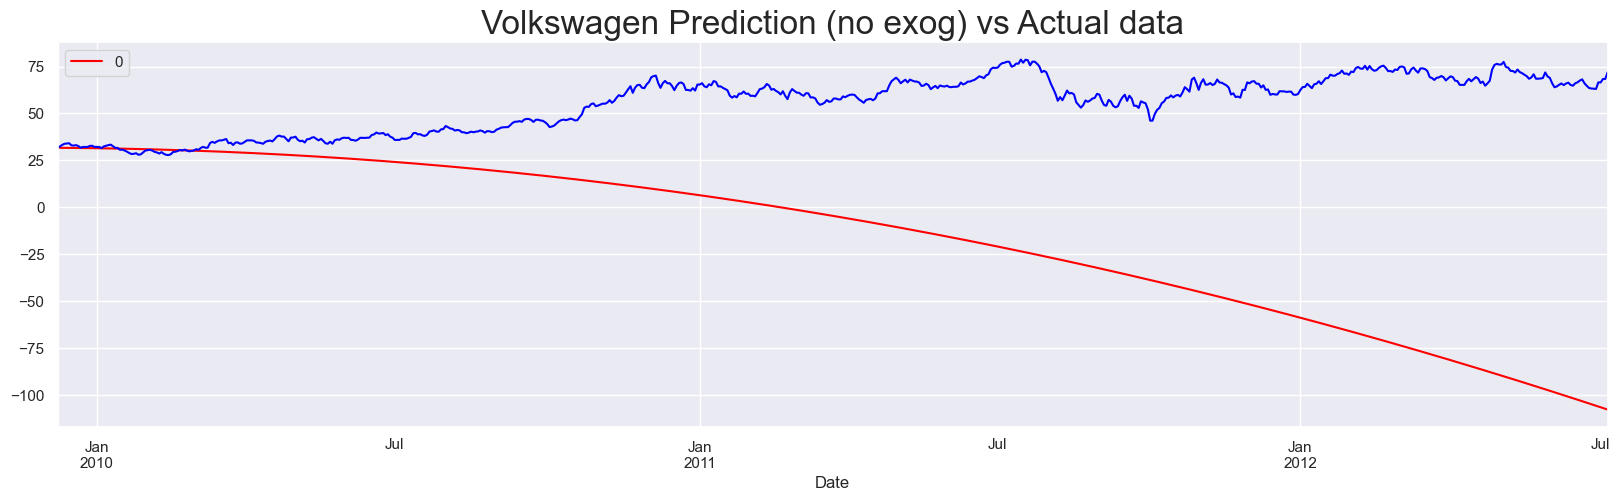

In [31]:
# Best model before announcement
model_auto_vol_we = auto_arima(df.vol[start_date:ann_1], m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2, trend='ct')

# Model Prediction
df_auto_pred_vol_we = pd.DataFrame(model_auto_vol_we.predict(n_periods=len(df[ann_1:ann_2])), index=df[ann_1:ann_2].index)

# Plot of the prediction compared to the actual value
df_auto_pred_vol_we.plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title('Volkswagen Prediction (no exog) vs Actual data', size=24)
plt.show()

### For Volkswagen (with porsche exog)

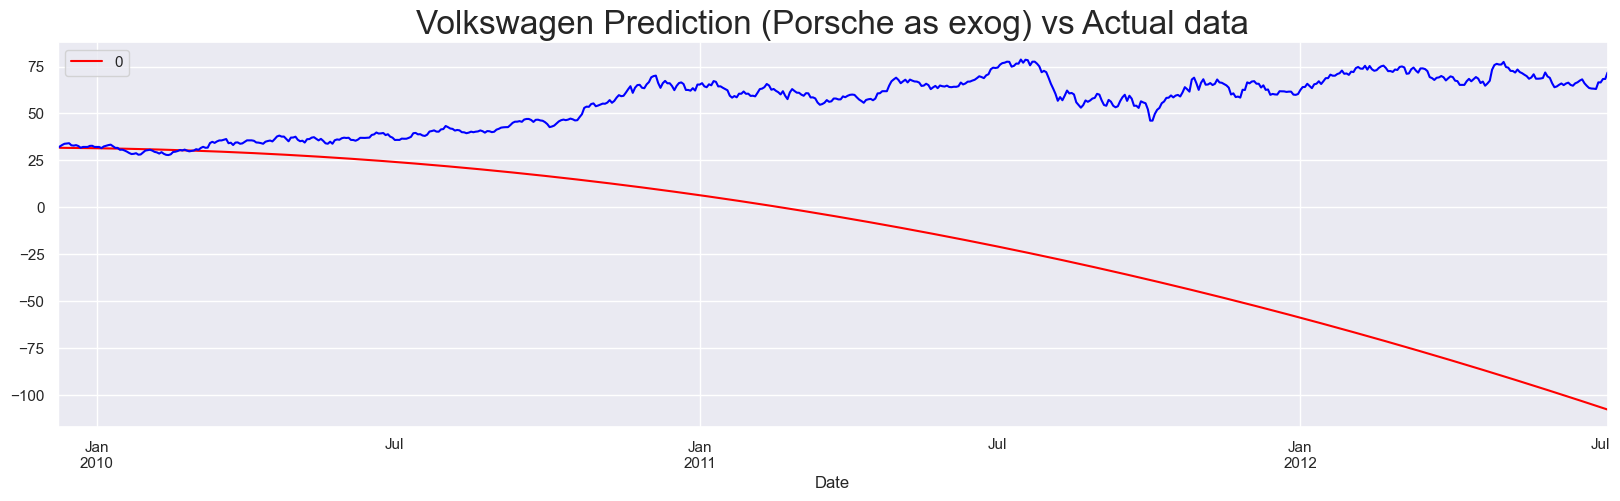

In [32]:
# Best model before announcement
model_auto_vol_por = auto_arima(df.vol[start_date:ann_1], exogenous=df[['por']][start_date:ann_1],
                               m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2, trend='ct')

# Model Prediction
df_auto_pred_vol_por = pd.DataFrame(model_auto_vol_por.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['por']][ann_1:ann_2]),
                                   index=df[ann_1:ann_2].index)

# Plot of the prediction compared to the actual value
df_auto_pred_vol_por.plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title('Volkswagen Prediction (Porsche as exog) vs Actual data', size=24)
plt.show()

### For Volkswagen (Bmw as exog)

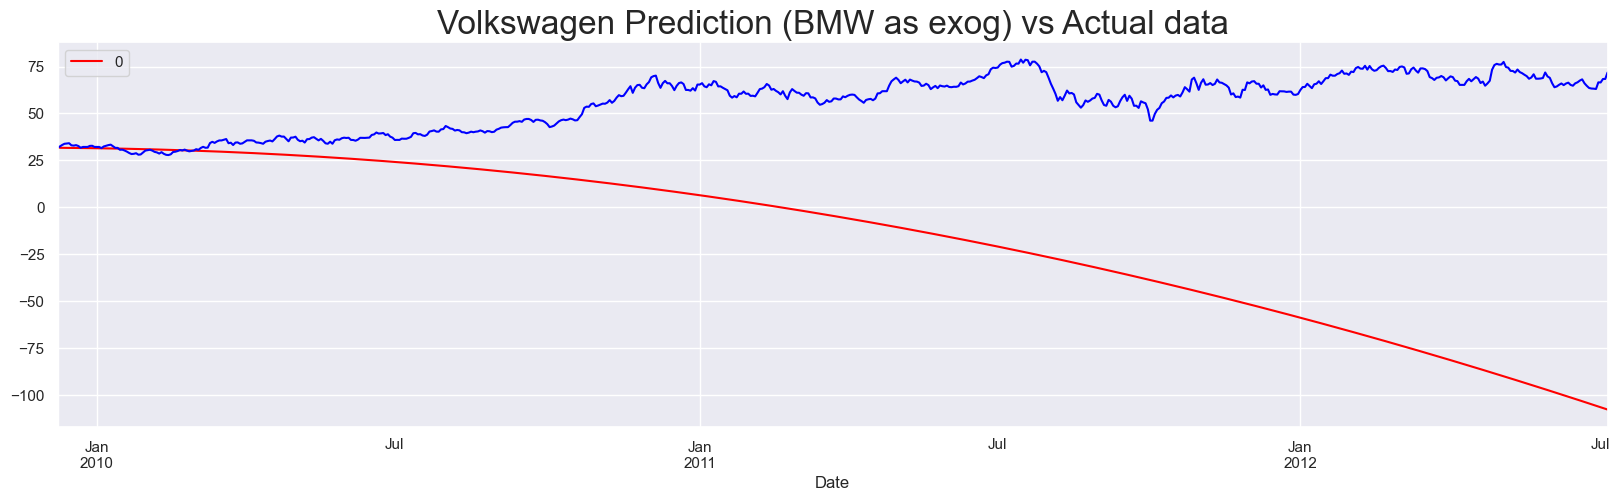

In [33]:
# Best model before announcement
model_auto_vol_bmw = auto_arima(df.vol[start_date:ann_1], exogenous=df[['bmw']][start_date:ann_1],
                               m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2, trend='ct')

# Model Prediction
df_auto_pred_vol_bmw = pd.DataFrame(model_auto_vol_bmw.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['bmw']][ann_1:ann_2]),
                                   index=df[ann_1:ann_2].index)

# Plot of the prediction compared to the actual value
df_auto_pred_vol_bmw.plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title('Volkswagen Prediction (BMW as exog) vs Actual data', size=24)
plt.show()

### For Volkswagen (with both exog)

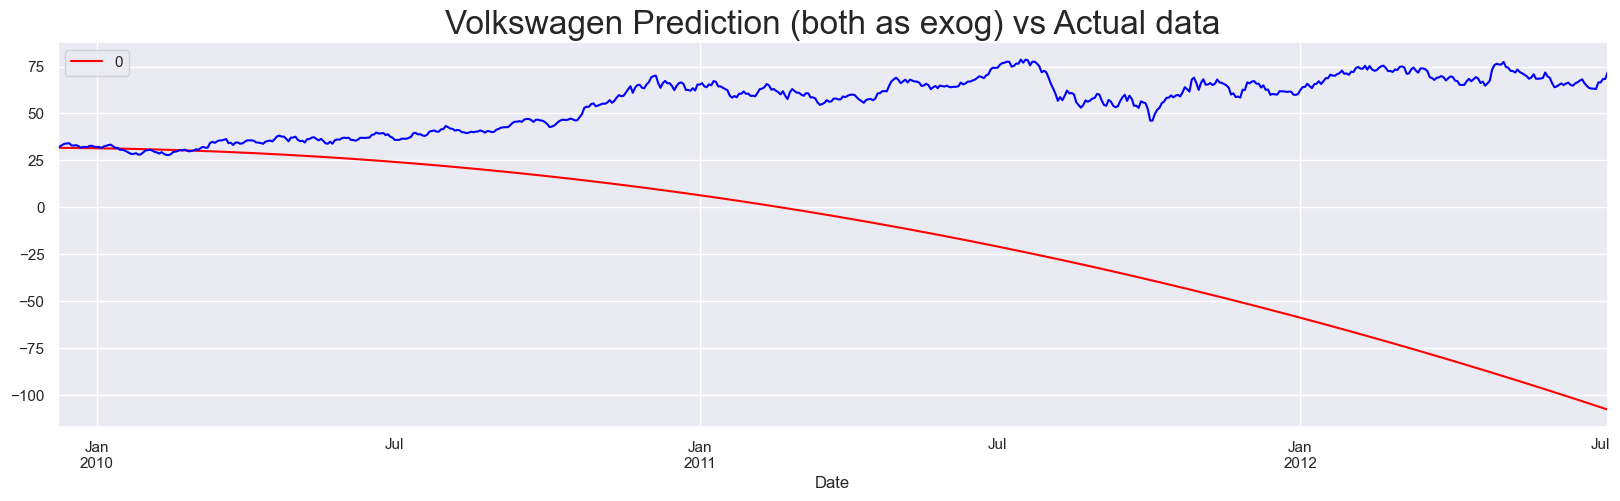

In [34]:
# Best model before announcement
model_auto_vol = auto_arima(df.vol[start_date:ann_1], exogenous=df[['por', 'bmw']][start_date:ann_1],
                               m=5, max_p=5, max_q=5, max_d=2, max_P=4, max_Q=4, max_D=2, trend='ct')

# Model Prediction
df_auto_pred_vol = pd.DataFrame(model_auto_vol.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['por', 'bmw']][ann_1:ann_2]),
                                   index=df[ann_1:ann_2].index)

# Plot of the prediction compared to the actual value
df_auto_pred_vol.plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title('Volkswagen Prediction (both as exog) vs Actual data', size=24)
plt.show()

## Volatility

### Volatility of Volkswagen for each periods

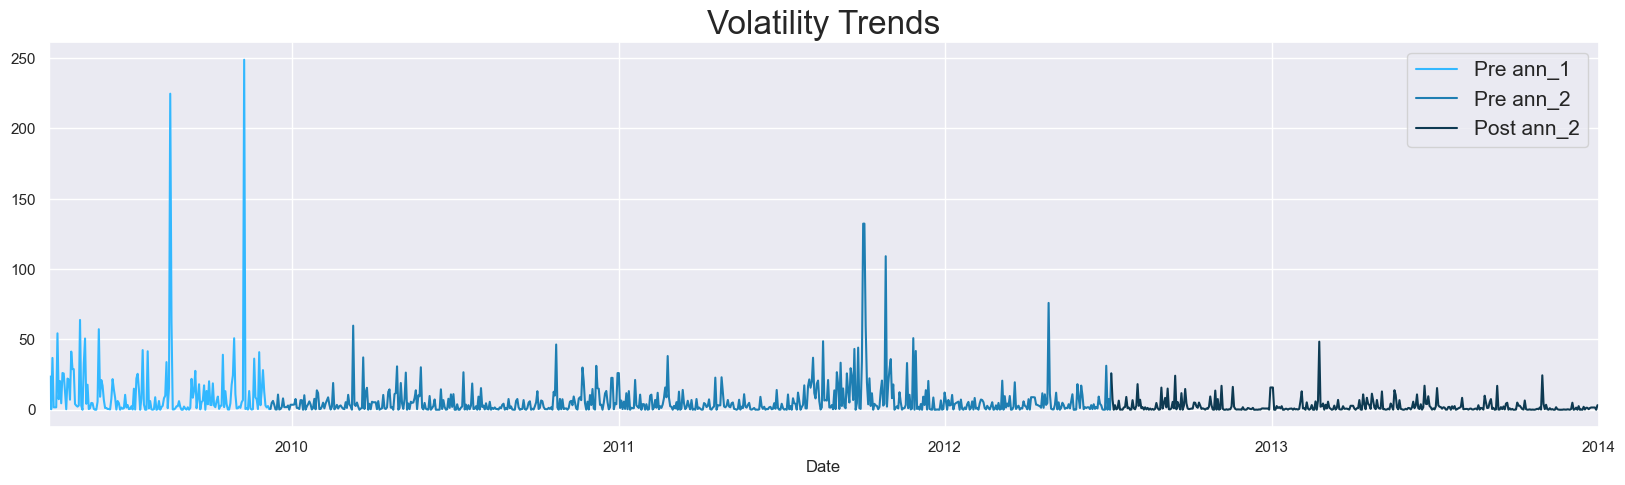

In [35]:
df.sq_vol[start_date:ann_1].plot(figsize=(20, 5), color='#33B8FF')
df.sq_vol[ann_1:ann_2].plot(color='#1E7EB2')
df.sq_vol[ann_2:end_date].plot(color='#0E3A52')
plt.title('Volatility Trends', size=24)
plt.legend(['Pre ann_1', 'Pre ann_2', 'Post ann_2'], fontsize=15)
plt.show()

### Volatility trends for each period

In [36]:
# Volatility before announcement
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean='Constant', vol='GARCH', p=1, q=1)
results_garch_pre = model_garch_pre.fit(update_freq=5)

# Volatility after first anouncement
model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean='Constant', vol='GARCH', p=1, q=1)
results_garch_btn = model_garch_btn.fit(update_freq=5)

# Volatility after second announcement
model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean='Constant', vol='GARCH', p=1, q=1)
results_garch_post = model_garch_post.fit(update_freq=5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7774739435034
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.0030743665935
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.9904199807369
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.99041992844434
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7534224370045
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7314912473807
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7314912461356
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5623228457273
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5579633645725
            Iterations: 7
            

In [37]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.990
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Sun, Oct 06 2024   Df Residuals:                      177
Time:                        06:47:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.195e-02      1.675  9.400e-02 [-2.623e-02,  0.334]
beta[1]        0.0000      0.349      0.000      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [38]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Sun, Oct 06 2024   Df Residuals:                      671
Time:                        06:47:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [39]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Sun, Oct 06 2024   Df Residuals:                      389
Time:                        06:47:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""

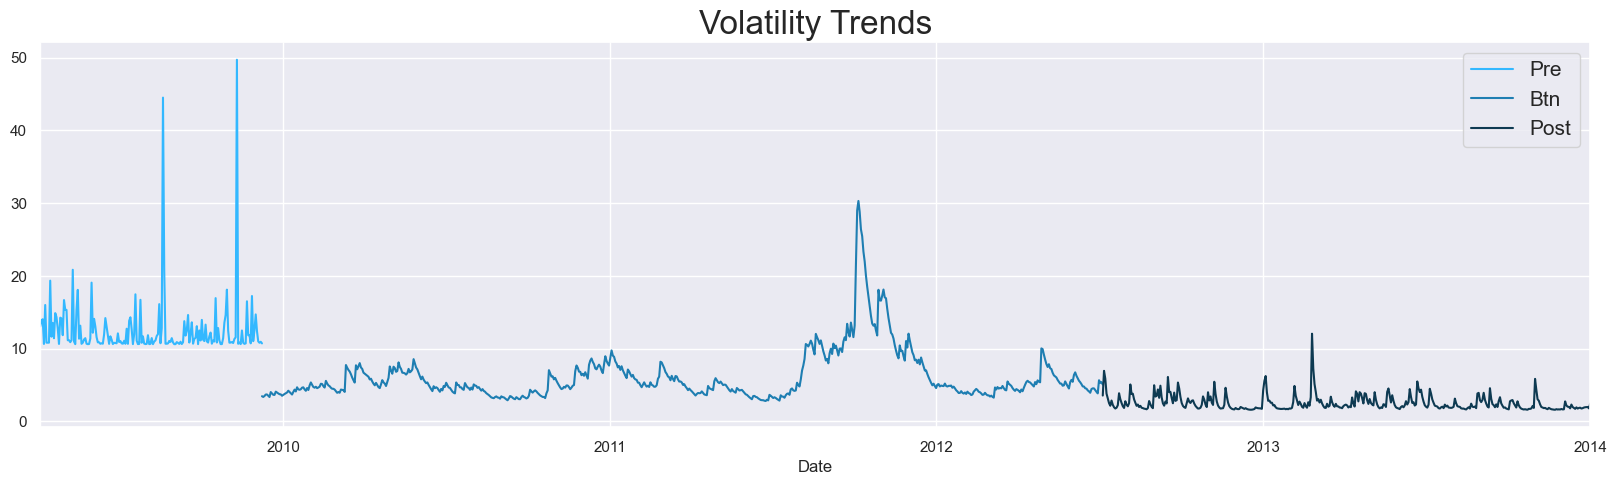

In [40]:
(results_garch_pre.conditional_volatility[start_date:ann_1] ** 2).plot(figsize=(20, 5), color='#33B8FF')
(results_garch_btn.conditional_volatility[ann_1:ann_2] ** 2).plot(color='#1E7EB2')
(results_garch_post.conditional_volatility[ann_2:end_date] ** 2).plot(color='#0E3A52')
plt.title('Volatility Trends', size=24)
plt.legend(['Pre', 'Btn', 'Post'], fontsize=15)
plt.show()